# Chemical Propeties 
Here, we will evaluate the quantity and some chemical properties of the generated PKA compounds:
1. Chirality
2. (HYDE) binding affinity
3. Drug-likeness and bioavailability

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML
from kinfraglib import utils
from rdkit import Chem
from rdkit.Chem import QED, AllChem, Descriptors, Draw, Lipinski, PandasTools, rdMolDescriptors
from src.evaluation.utils import read_mols

PandasTools.RenderImagesInAllDataFrames(images=True)

## Prepare ligands
Load generated ligands to dataframe and removed all ligands with an estimated binding affinity of > 1,000 nm (unfavoured)

In [2]:
# read data
data = read_mols('../results_5n1f_25_02/5n1f/results.sdf')

In [ ]:
num_compounds = data.shape[0]
print(f"Total number of compounds: {num_compounds}")
print(f"Post-filter --->")
data = data[data['binding_affinity'] <= 1000].copy() 
print(f'Removed {100-data.shape[0]/num_compounds * 100:.1f}% compounds (noise)')
print(f"Number of compounds with binding affinity <= 1000 nM: {data.shape[0]}")
for unique_val in pd.unique(data['num_fragments']):
    print(f"Number of ligands comprising {unique_val} fragments: {sum(x == unique_val for x in data['num_fragments'])}")

print(f'Number of compounds with binding affinity less than 100nM: {sum(data["binding_affinity"] < 100)}')

Total number of compounds: 1166
Post-filter --->
Removed 0.00% compounds (noise)
Number of compounds with binding affinity <= 1000 nM: 1166
Number of ligands comprising 2 fragments: 1104
Number of ligands comprising 3 fragments: 62
Number of compounds with binding affinity less than 100nM: 155


,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,GA_smiles,AP_smiles_dummy,FP_smiles_dummy,GA_smiles_dummy,AP,FP,GA
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",N#Cc1c[nH]c2ncccc12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,None,[4*]c1ccnc2[nH]cc(C#N)c12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,None,136,8,NaN
1,,0.853035,300.13,3,InChI=1S/C24H27N5O2/c1-16-23-21(27-26-16)7-4-8...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,COCc1ccccc1,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[18*]c1cccc(COC)c1,297,51,114.0
2,,1.037959,3151.95,3,"InChI=1S/C26H23ClN4O4S/c1-15-13-17(36(3,32)33)...",Nc1nccc2c(Cl)coc12,Cc1cc(S(C)(=O)=O)ccc1-c1nccn1C,OCc1ccccc1,[21*]c1cnc(N)c2oc([36*])c(Cl)c12,[28*]c1nc(-c2ccc(S(C)(=O)=O)cc2C)n(C)c1[39*],[10*]c1ccc(CO[24*])cc1,400,335,98.0
3,,1.509653,1481.09,3,InChI=1S/C22H21Cl2N5O/c1-13-21-19(27-26-13)3-2...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,Clc1ccccc1Cl,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[3*]c1ccc(Cl)c(Cl)c1,297,51,86.0
4,,1.553260,7036.25,3,InChI=1S/C31H36FN3OS/c1-5-21-16-26(36)25(32)17...,c1cc2ccsc2cn1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,CCc1ccc(F)c(O)c1,[15*]c1c([24*])sc2cnccc12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,[31*]c1cc(F)c(O)cc1CC,49,8,85.0

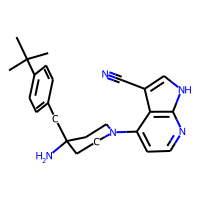
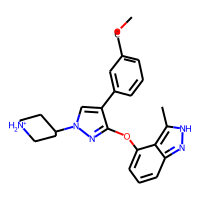
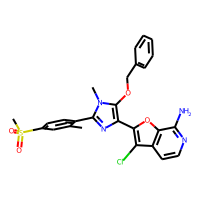
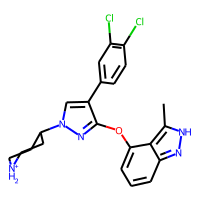
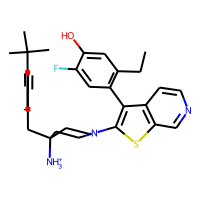

In [4]:
# sort compounds by binding affinity 
data = data.sort_values(['binding_affinity']).reset_index(drop=True)
HTML(data.head().to_html(notebook=True))

## 1. Chirality
Ligands with a chiral centre might be unfavoured, e.g. for sythesis. 

In [5]:
data['has_chiral_centre'] = data.apply(lambda x: len(Chem.FindMolChiralCenters(utils.standardize_mol(x.ROMol), includeUnassigned=True, useLegacyImplementation=False)) != 0, axis=1)
print(f"Compounds with chiral centre: {sum(data['has_chiral_centre'])} ({(sum(data['has_chiral_centre']) / data.shape[0]) * 100}%)")

Compounds with chiral centre: 315 (27.01543739279588%)


Sample ligands with chiral centre:

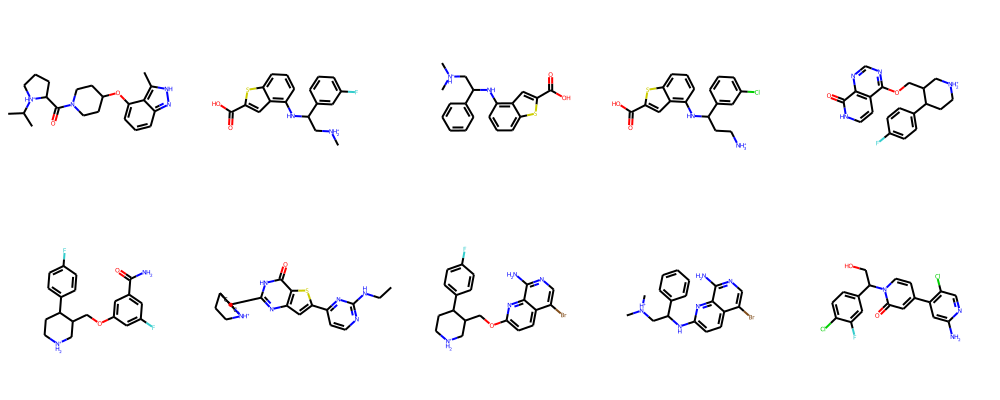

In [6]:
# show sample molecules with chiral centre
mols = [data[data['has_chiral_centre']].reset_index().ROMol[idx] for idx in range(10)]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(200, 200)
)
img

## 2. Estimated Binding Affinity (HYDE)
Here, will will take a look at the estimated binding affinity (HYDE score) of the best scoring docking pose of our generated PKA ligands. We will first inspect the $25$ compounds with the best estimated binding affinity. After that, we will look at the distribution of the binding affnity and compare it across different ligand sizes.

**Note:** The dataset only comprises those ligands with a estimated binding affinity of $\leq 1,000$ nM as ligands with very high (unfavoured) estimated affinity were removed earlier.

Top 25 ranked compounds


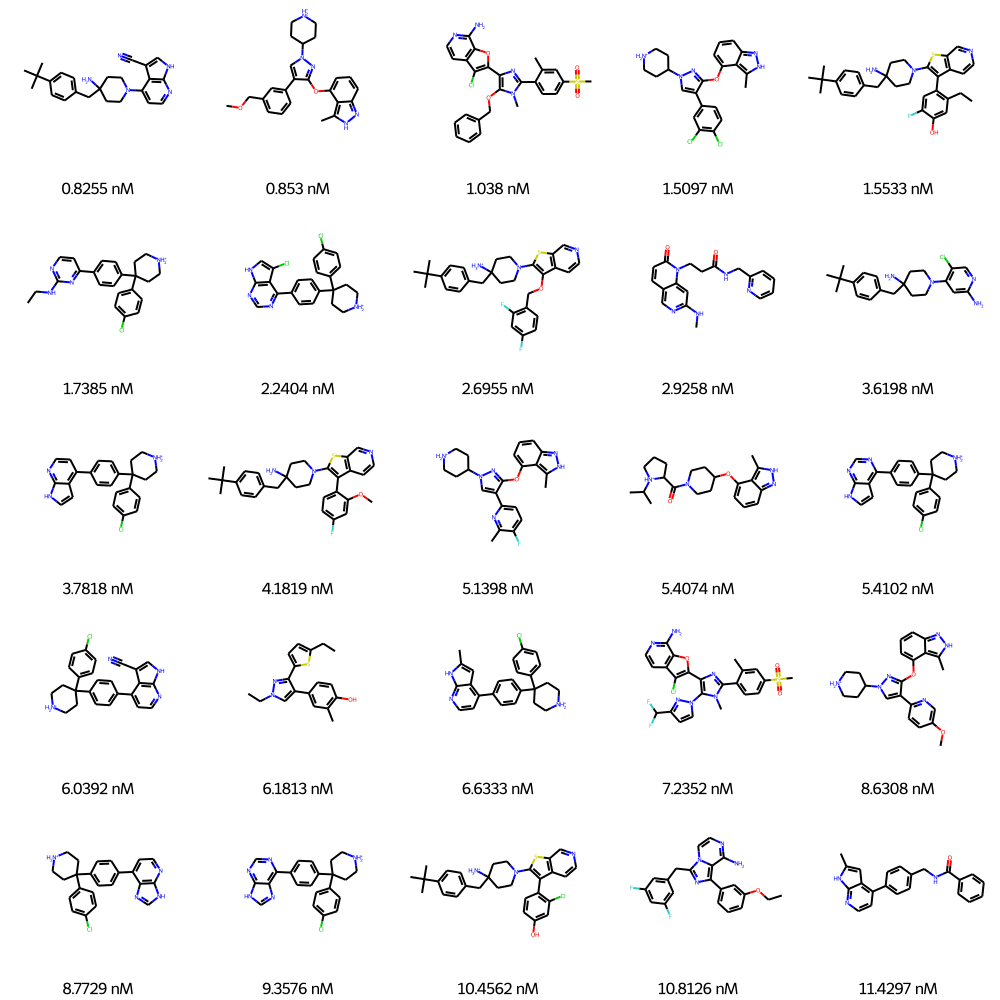

In [7]:
print("Top 25 ranked compounds")
mols = [data.ROMol[idx] for idx in range(25)]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols, 
    legends=[
        f"{round(data['binding_affinity'][idx],4)} nM"  
        for idx in range(25)
    ],  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(200, 200)
)
img

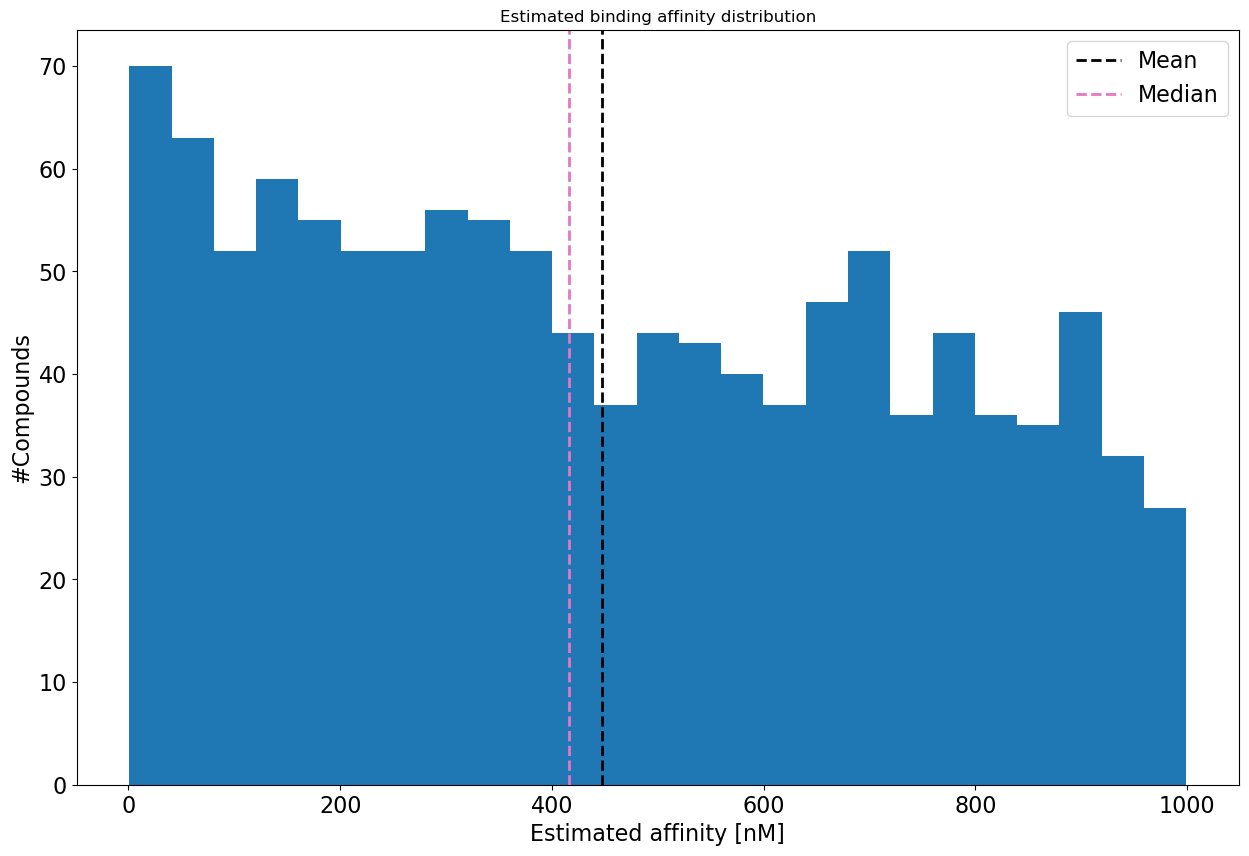

In [8]:
plt.figure(figsize=(15, 9.8))
plt.hist(data.binding_affinity, bins=25)
plt.ylabel("#Compounds", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Estimated affinity [nM]', fontsize=16)
plt.title("Estimated binding affinity distribution")
mean_line = plt.axvline(data.binding_affinity.mean(), color='k', linestyle='dashed', linewidth=2, label="Mean")
median_line = plt.axvline(data.binding_affinity.median(), color='tab:pink', linestyle='dashed', linewidth=2, label="Median")
plt.legend(handles = [mean_line, median_line], fontsize=16)
plt.show()

In [9]:
print(f"Statistics of binding affinity (post-filtered): \n{data['binding_affinity'].describe()}")
print(f"Estimated binding affinity [nM] median: {data['binding_affinity'].median()}")

Statistics of binding affinity (post-filtered): 
count    1166.000000
mean      446.800486
std       286.703429
min         0.825466
25%       194.520934
50%       415.873911
75%       691.472344
max       999.017321
Name: binding_affinity, dtype: float64
Estimated binding affinity [nM] median: 415.87391149999996


#### Binding affinity per subpocket

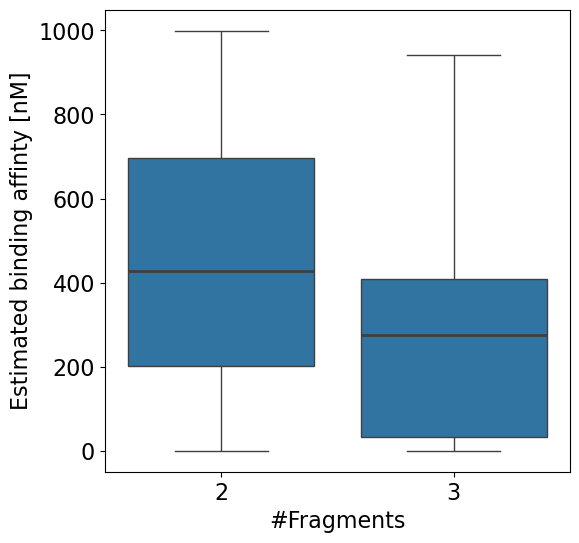

In [10]:
plt.figure(figsize=(6, 6))

bp = sns.boxplot(
x="num_fragments",
y='binding_affinity',
data=data,
medianprops={"linewidth": 2, "linestyle": "-"},
)
plt.ylabel("Estimated binding affinty [nM]", fontsize=16)
plt.xlabel("#Fragments", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

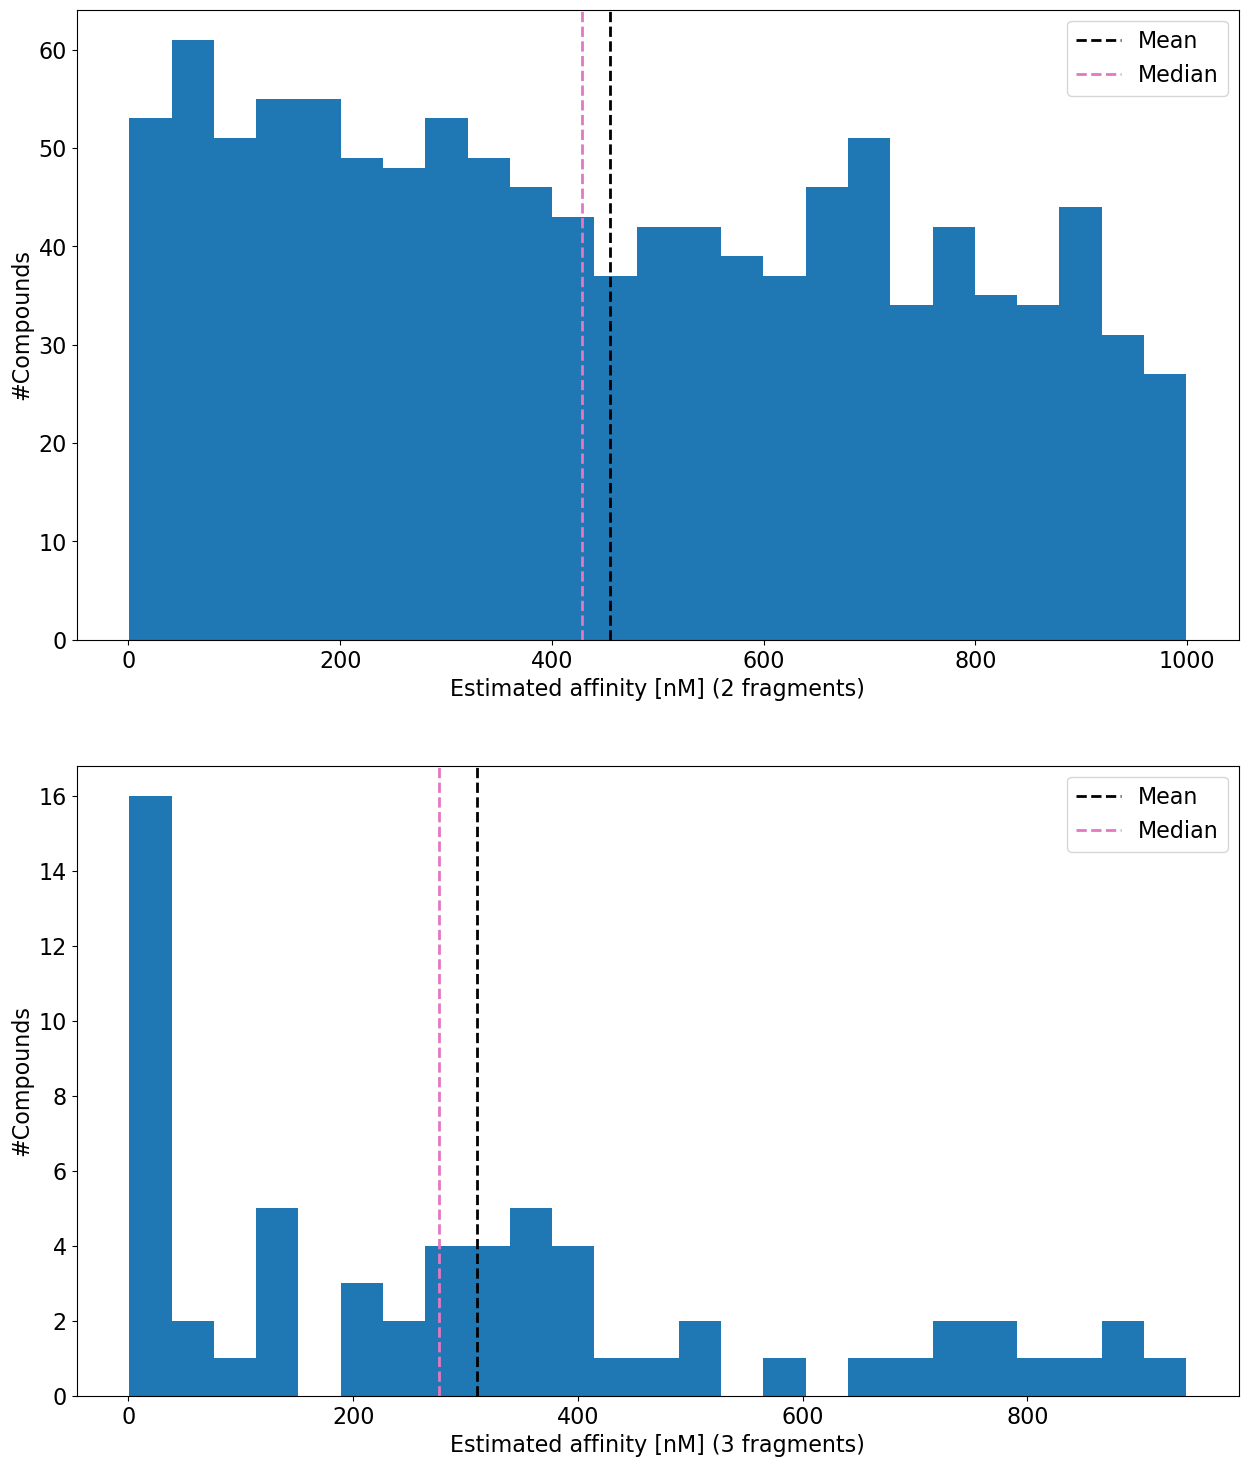

In [11]:
plt.rc('font', size=16) 
fig, axis = plt.subplots(2, 1, figsize=(15, 18))
descriptors = range(2, 4)
for i, descriptor_name in enumerate(descriptors):
        x = data[data.num_fragments == descriptor_name].binding_affinity
        axis[i].hist(x, bins=25)
        axis[i].set(ylabel="#Compounds", xlabel=f"Estimated affinity [nM] ({descriptor_name} fragments)")
        median_line = axis[i].axvline(x.median(), color='tab:pink', linestyle='dashed', linewidth=2, label="Median")
        line = axis[i].axvline(x.mean(), color='k', linestyle='dashed', linewidth=2, label = f"Mean")
        axis[i].legend(handles = [line, median_line], fontsize=16)

In [12]:
for descriptor_name in range(2, 4):
    x = data[data.num_fragments == descriptor_name].binding_affinity
    print(f'Binding Affinity statistics of compounds with {descriptor_name} fragments:\n{x.describe()}')
    print(f"Median: {x.median()}")

Binding Affinity statistics of compounds with 2 fragments:
count    1104.000000
mean      454.460036
std       285.223784
min         0.825466
25%       201.972288
50%       428.037310
75%       696.783785
max       999.017321
Name: binding_affinity, dtype: float64
Median: 428.03730975
Binding Affinity statistics of compounds with 3 fragments:
count     62.000000
mean     310.411088
std      280.854774
min        0.853035
25%       32.383662
50%      276.828431
75%      409.621195
max      941.466217
Name: binding_affinity, dtype: float64
Median: 276.828431


## 3. Drug-likeness and bioavailability
To analyse the drug-like capcity and bioavailabity of the generated PKA compounds, we consider Lipinski's Rule of Five and Vebers rules, as well as the Quantitative Estimated Druglikeness (QED) score.

### 3.1 Lipinski's Rule of Five and Vebers properties
We first inspect the four propeties of Lipinski's Rule of Five (Ro5):
- molecular weight (MW)
- Number of hydrogen bond donors (HBD) and acceptors (HBA)
- logP

Lipinski proposes the following benchmarks for assessing the bioavailability of compounds:
- MW $<500$ g mol $^{-1}$
- $\leq 5$ HBD
- $\leq 10$ HBA
- logP $<5$

In addition, we measure the topological polar surface area (TPSA) and rotable bonds (RB), since Veber proposed the following additional benchenmarks for bioavailability:
- TPSA $\leq 140$ Å
- $5 \leq$ RB

**Note:** Although Lipinski conducted these benchmark for oral administration of drugs, it is often used to access the drug-likeliness and bioavailability of compounds

In [13]:
# HBD & HBA
data['HBD'] = data['ROMol'].apply(Lipinski.NumHDonors)
data['HBA'] = data['ROMol'].apply(Lipinski.NumHAcceptors)
# molecular weight
data['MW'] = data['ROMol'].apply(Descriptors.ExactMolWt)
#logP
data['logP'] = data['ROMol'].apply(Descriptors.MolLogP)
#rename tpsa
data['RB'] = data['ROMol'].apply(Descriptors.NumRotatableBonds)
data['TPSA'] = data['ROMol'].apply(rdMolDescriptors.CalcTPSA)

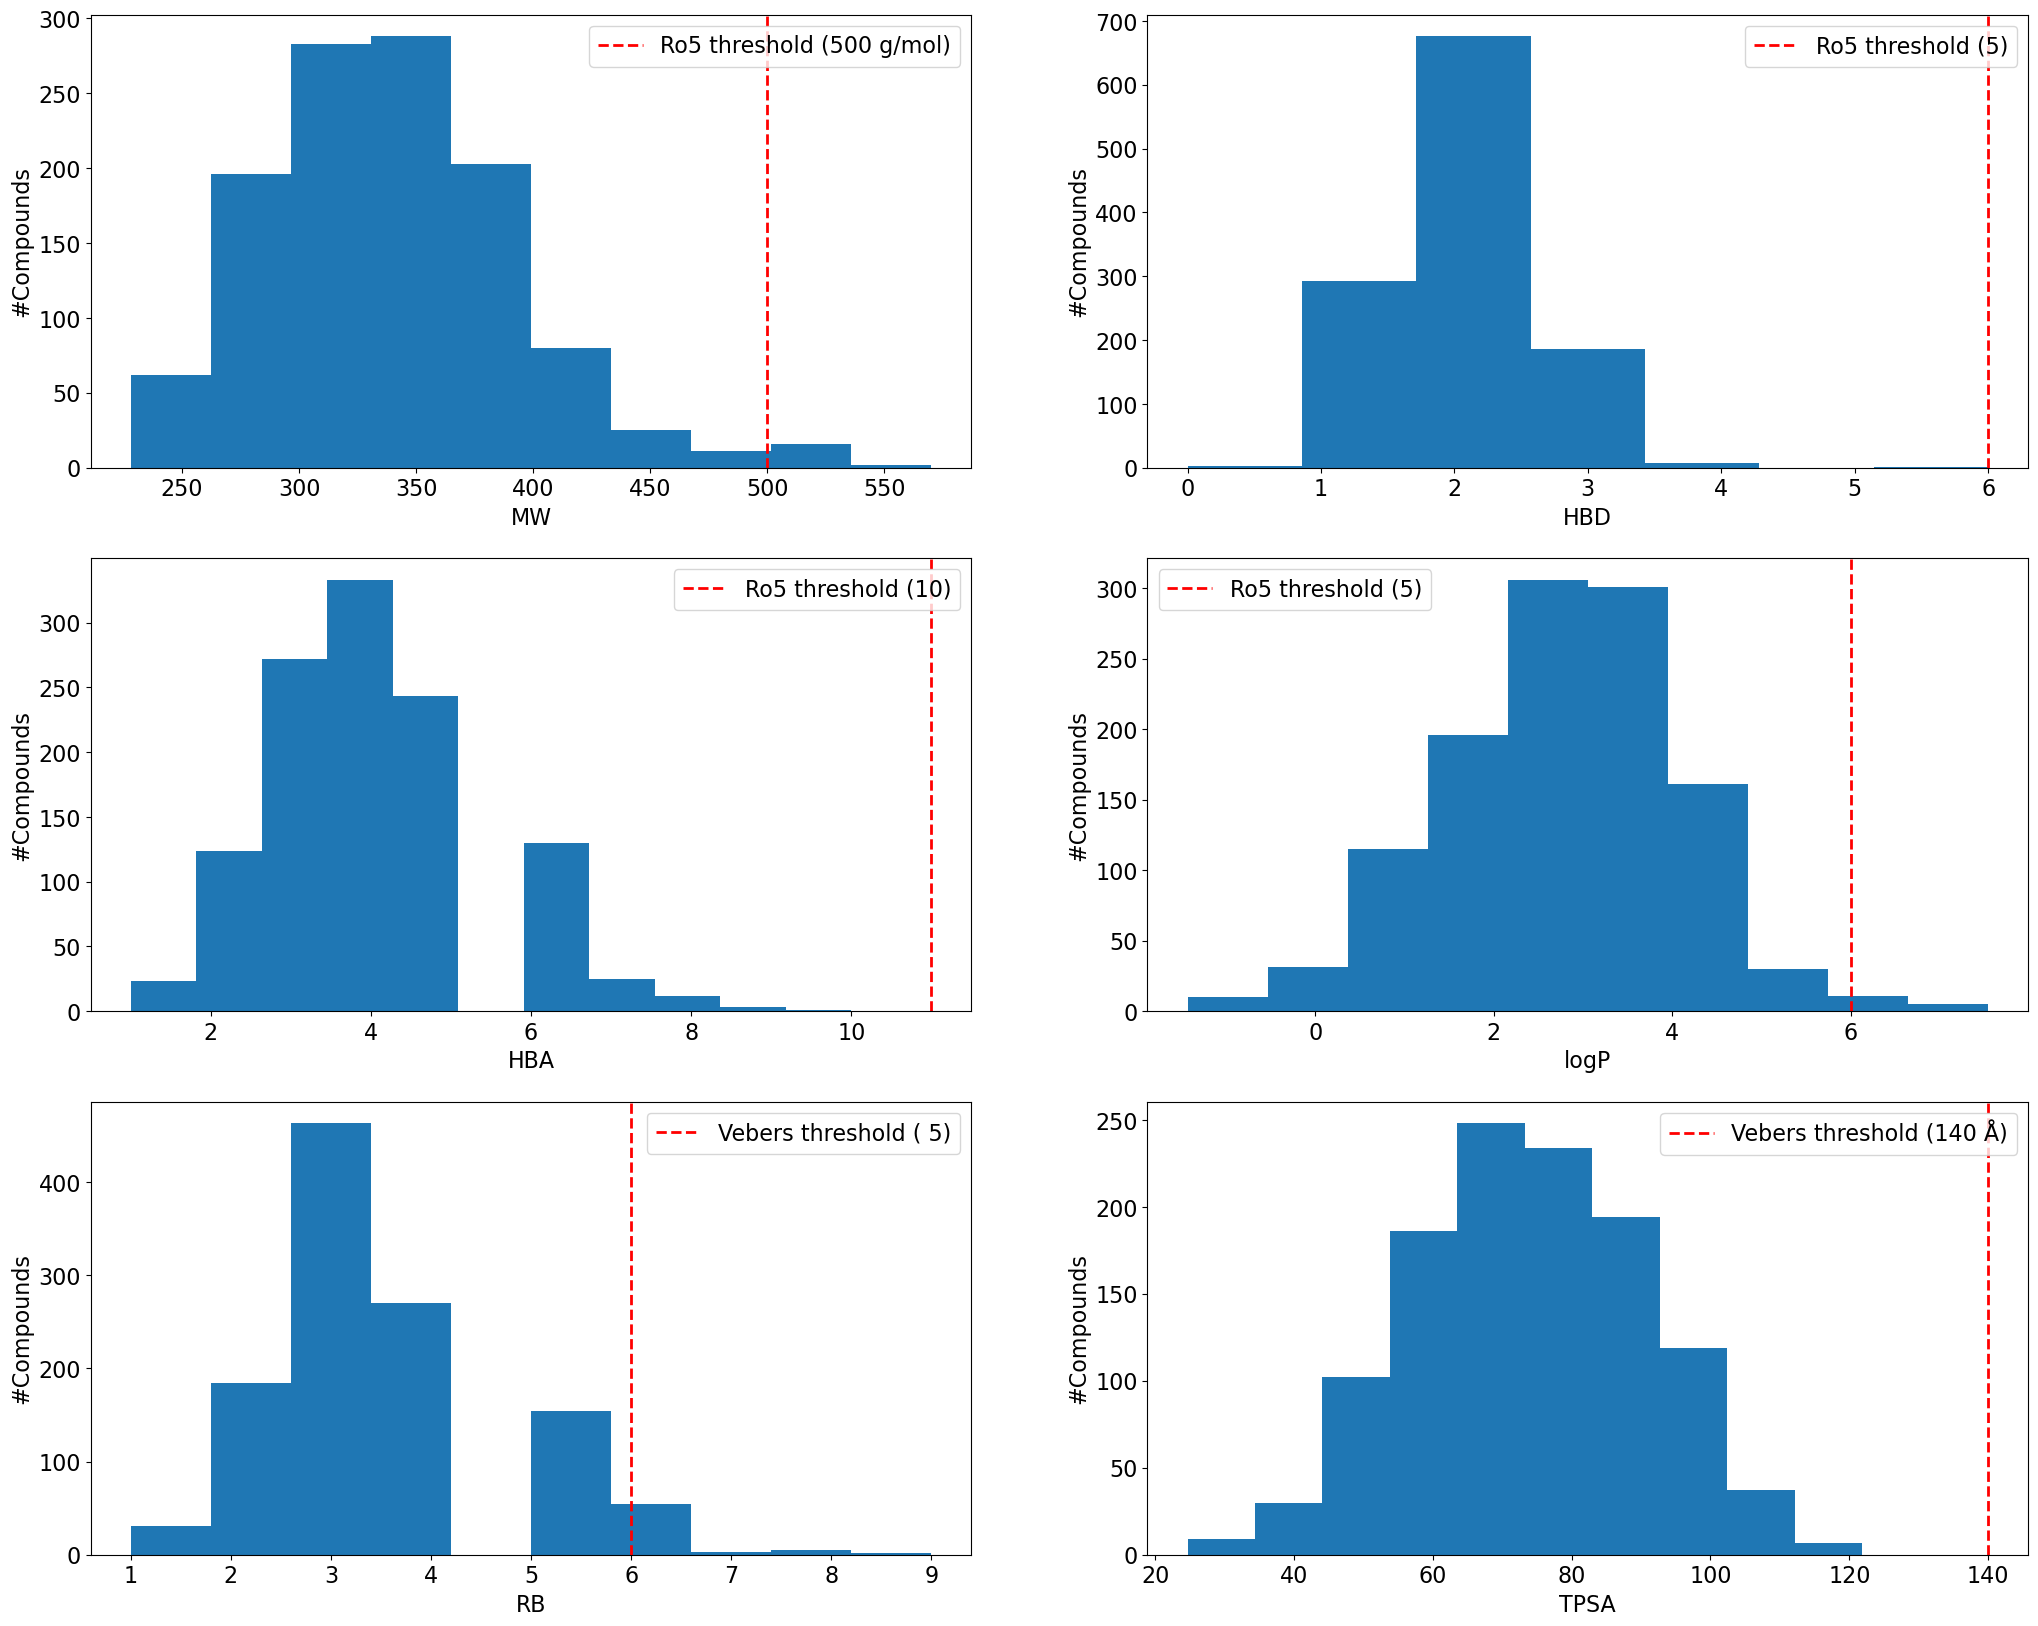

In [21]:
# plot Ro5 properties on reduced data
plt.rc('font', size=16) 
fig, axis = plt.subplots(3, 2)
fig.set_size_inches(25, 20)
descriptors = ['MW', 'HBD', 'HBA', 'logP', 'RB', 'TPSA']
rule_sets = ['Ro5', 'Ro5', 'Ro5', 'Ro5', 'Vebers', 'Vebers']
benchmarks = [500, 6, 11, 6, 6, 140]
labels = ['500 g/mol', '5', '10', '5',' 5', '140 Å']
for i, (descriptor_name, rule_set, label) in enumerate(zip(descriptors, rule_sets, labels)):
        if descriptor_name == 'HBD':
                axis[i // 2, i % 2].hist(data[descriptor_name], bins=7)
        elif  descriptor_name == 'HBA': 
                axis[i // 2, i % 2].hist(data[descriptor_name], bins=11)
        elif  descriptor_name == 'RB': 
                axis[i // 2, i % 2].hist(data[descriptor_name], bins=10)
        else:
                axis[i // 2, i % 2].hist(data[descriptor_name])
        axis[i // 2, i % 2].set(ylabel="#Compounds", xlabel=descriptor_name)
        line = axis[i // 2, i % 2].axvline(benchmarks[i], color='r', linestyle='dashed', linewidth=2, label = f"{rule_set} threshold ({label})")
        axis[i // 2, i % 2].legend(handles=[line])


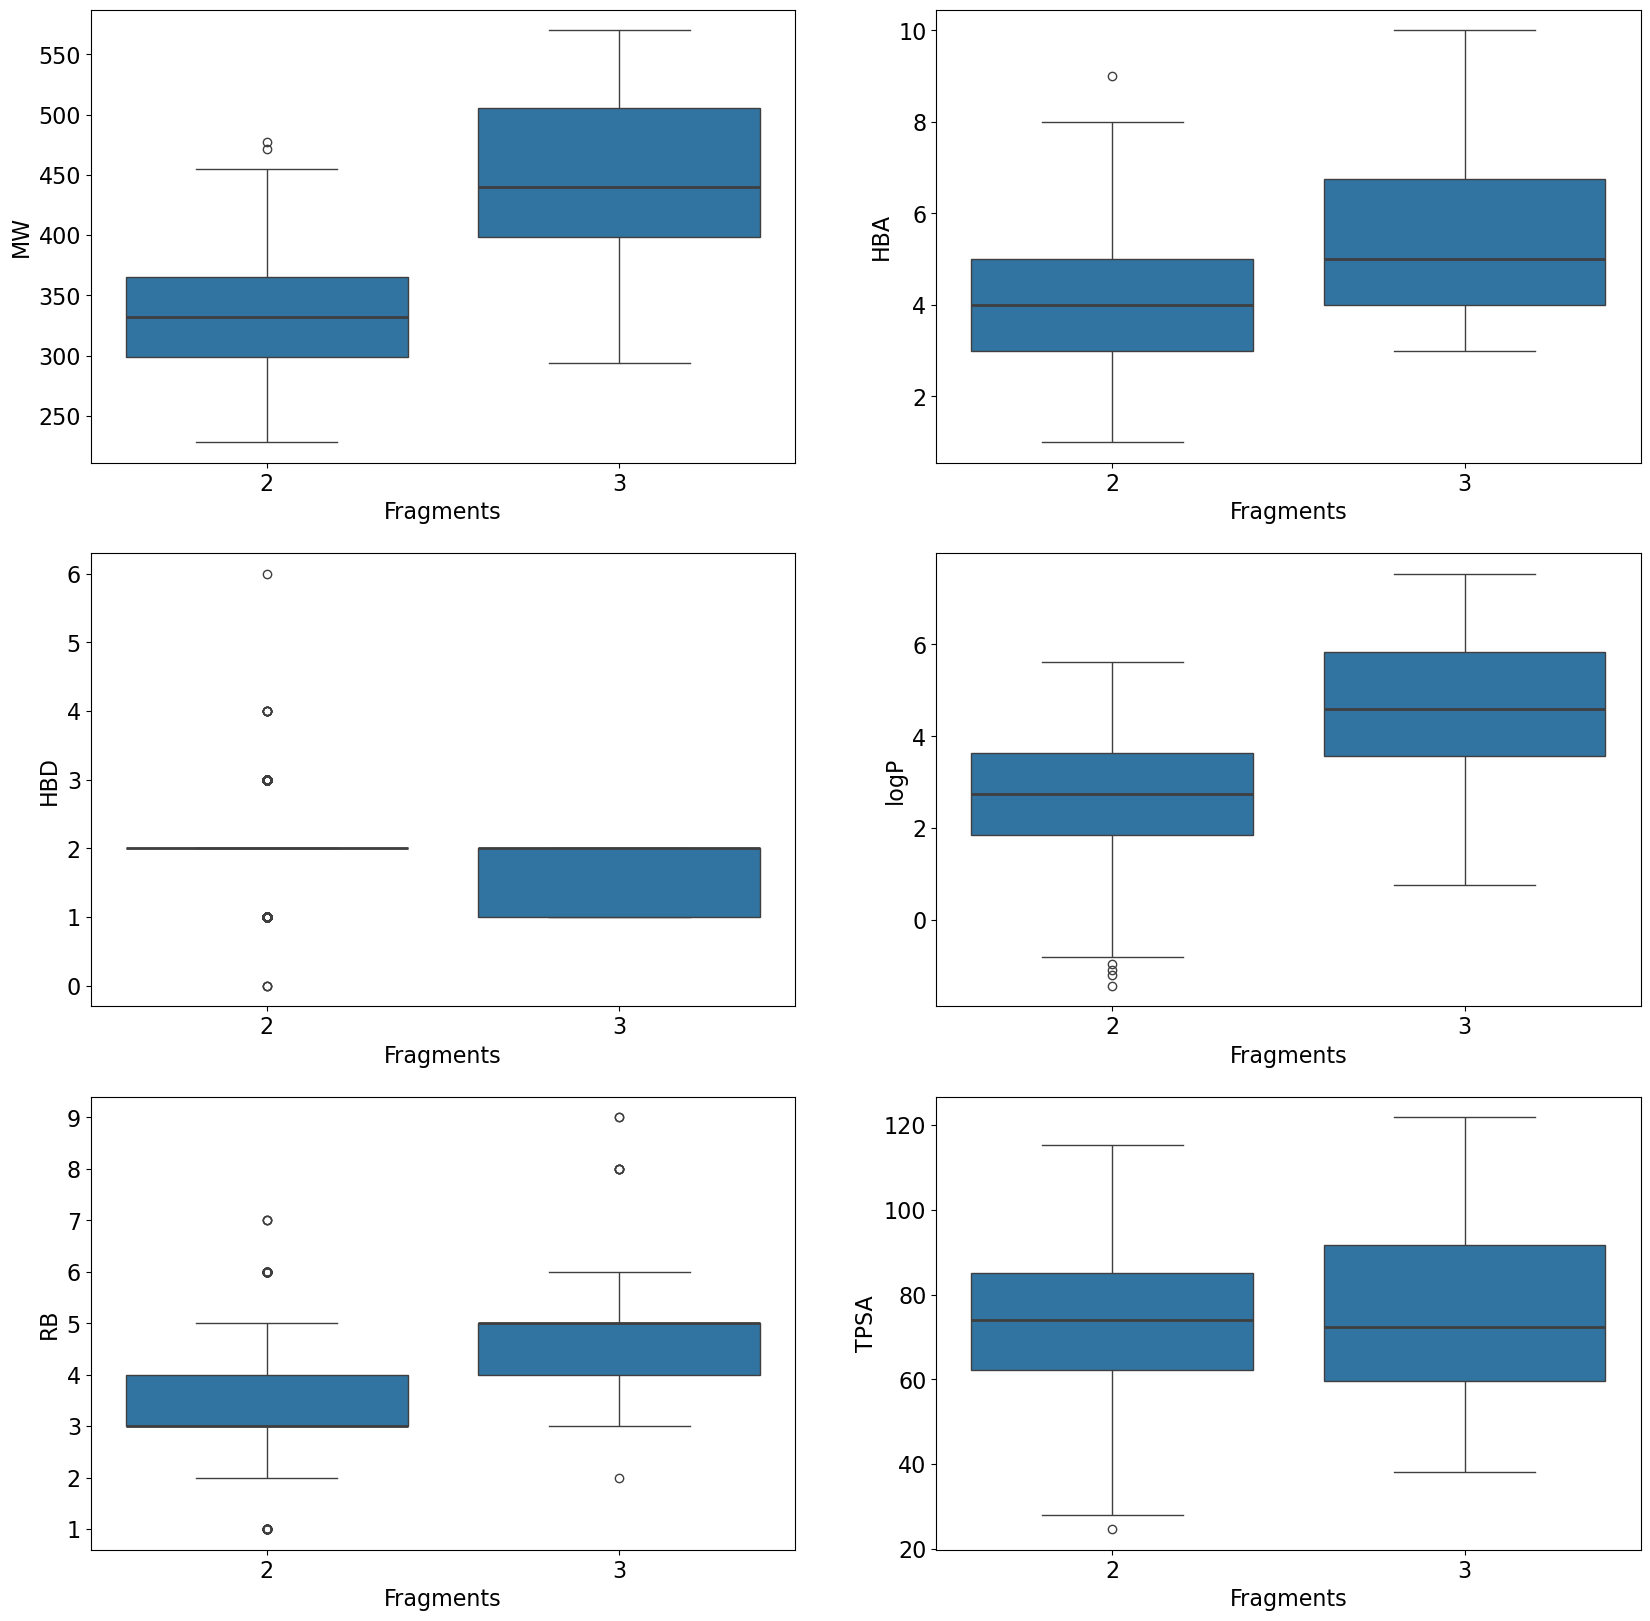

In [ ]:
plt.figure(figsize=(20, 20))
descriptors = ['MW', 'HBA', 'HBD', 'logP', 'RB', 'TPSA']
for i, descriptor_name in enumerate(descriptors):
        plt.subplot(3, 2, i + 1)
        sns.boxplot(
        x="num_fragments",
        y=descriptor_name,
        data=data,
        medianprops={"linewidth": 2, "linestyle": "-"},
        )
        plt.ylabel(descriptor_name, fontsize=16)
        plt.xlabel("Fragments", fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

In [ ]:
for descriptor_name in range(2, 4):
    x = data[data.num_fragments == descriptor_name].logP
    print(f'logP median of compounds with {descriptor_name} fragments:\n{x.mean()}')

logP median of compounds with 2 fragments:
2.6898096472663156
logP median of compounds with 3 fragments:
4.654934516129035


After inspecting the molecular properties, we will in look at the four Ro5 and the two Veber's rules.

In [22]:
# rule of five fullfilled
data['Ro5'] = data.apply(lambda x: x.HBD <= 5 and x.HBA <= 10 and x.MW <= 500 and x.logP <= 5, axis=1)

# rule of five fullfilled
data['Veber'] = data.apply(lambda x: x.TPSA <= 140 and x.RB <= 5, axis=1)

In [23]:
print(f'{sum(data["logP"] > 5)} compounds with logP > 5')
print(f'{sum(data["MW"] > 500)} compounds with MW > 500')
print(f'{sum(data["RB"] > 5)} compounds with RB > 5')
print(f'{sum(data["HBD"] > 5)} compounds with HBD > 5')
print(f'{sum(data["HBA"] > 10)} compounds with HBA > 10')
print(f'{sum(data["TPSA"] > 140)} compounds with TPSA > 140')

37 compounds with logP > 5
20 compounds with MW > 500
64 compounds with RB > 5
1 compounds with HBD > 5
0 compounds with HBA > 10
0 compounds with TPSA > 140


In [27]:
# compounds fullfilling Ro5
print(f'{sum(data["Ro5"])} ({sum(data["Ro5"])/data.shape[0] * 100:.1f}%) compounds fulfill Ro5')
print(f'{sum(data["Veber"])} ({sum(data["Veber"])/data.shape[0] * 100:.1f}%) compounds fulfill Vebers rule')
print(f'{sum(data["Veber"] & data["Ro5"])} ({sum(data["Veber"] & data["Ro5"])/data.shape[0] * 100:.1f}%) compounds fulfill Vebers rule & Ro5')

1124 (96.4%) compounds fulfill Ro5
1102 (94.5%) compounds fulfill Vebers rule
1065 (91.3%) compounds fulfill Vebers rule & Ro5


Let's look at the 25 compounds with the best estimated binding affinity that fullfill both Vebers rules and Ro5.

In [ ]:
ro5_veber_fulfilled = data[data["Veber"] & data["Ro5"]].reset_index(drop=True)

Top 25 ranked compounds (fulfilling Ro5 and Vebers rule)


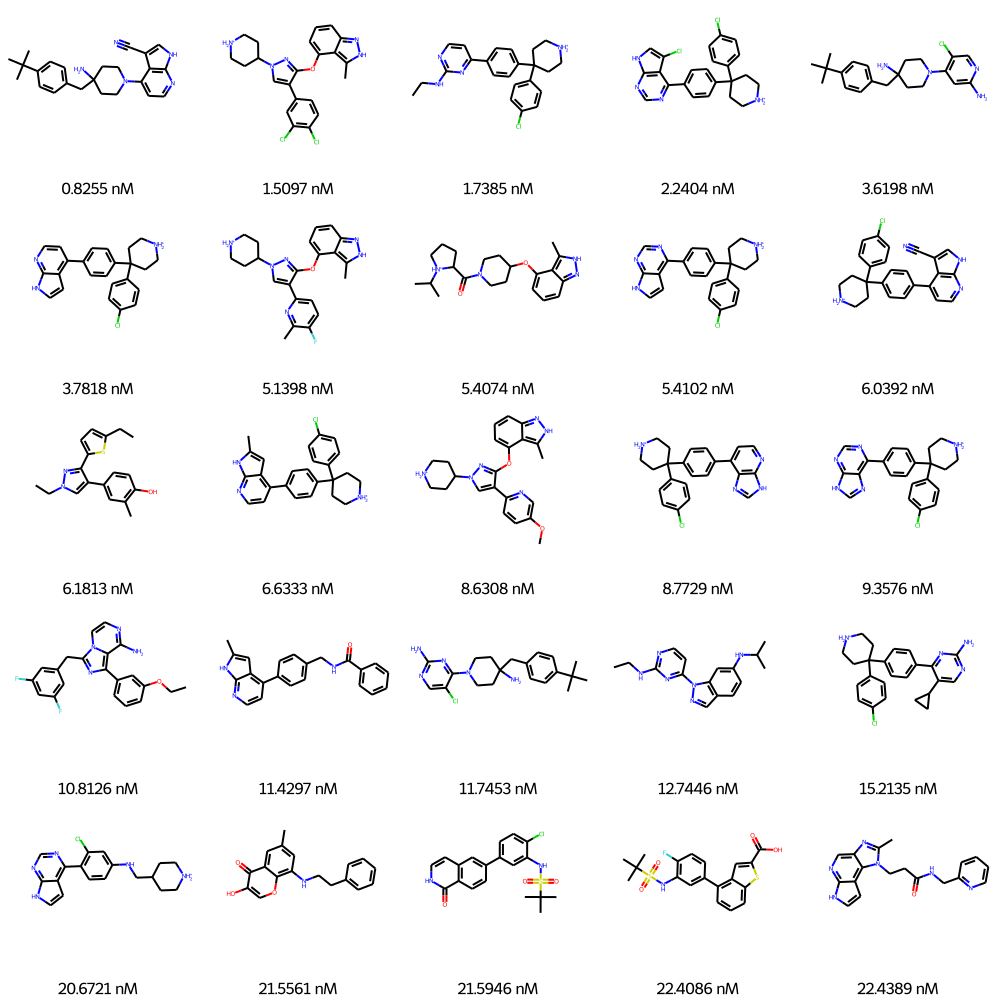

In [ ]:
print("Top 25 ranked compounds (fulfilling Ro5 and Vebers rule)")
mols = [ro5_veber_fulfilled.ROMol[idx] for idx in range(25)]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols,  
    molsPerRow=5, 
    legends=[f"{round(ro5_veber_fulfilled['binding_affinity'][idx],4)} nM" for idx in range(25)],
    maxMols=100,
    subImgSize=(200, 200)
)
img

### 3.2 QED
The QED score estimated a score for drug-likeness based on the molecular weight, number of hydrogen bond donors and acceptors, logP, number of rotable bonds, number of structural alerts and aromatic rings. A high QED score indicates that a compound is a drug-likely.

In [ ]:
# calculate the QED score of every compound
data['QED'] = data.apply(lambda x: QED.qed(x.ROMol), axis=1)

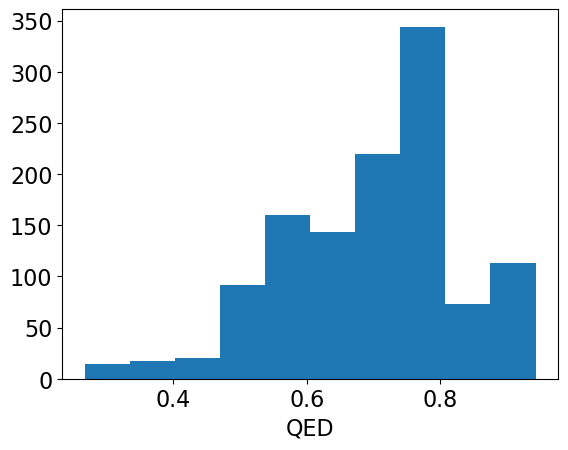

In [ ]:
# plot QED
plt.hist(data['QED'])
plt.xlabel('QED')
plt.show()

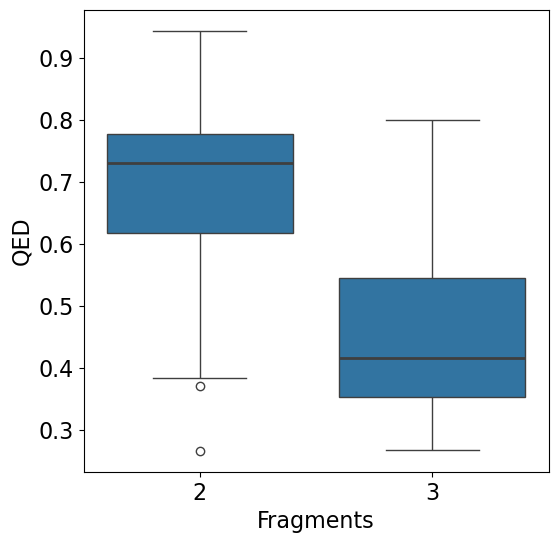

In [ ]:
plt.figure(figsize=(6, 6))

descriptors = ['QED']
for i, descriptor_name in enumerate(descriptors):
        plt.subplot(1, 1, i + 1)
        sns.boxplot(
        x="num_fragments",
        y=descriptor_name,
        data=data,
        medianprops={"linewidth": 2, "linestyle": "-"},
        )
        plt.ylabel(descriptor_name, fontsize=16)
        plt.xlabel("Fragments", fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)